In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import  *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
# from sklearn.neural_network import MLPClassifierr
from yellowbrick.classifier import ClassificationReport 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
chicago1 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2001_to_2004.csv", error_bad_lines=False, low_memory=False)
chicago2 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2005_to_2007.csv", error_bad_lines=False, low_memory=False)
chicago3 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2008_to_2011.csv", error_bad_lines=False, low_memory=False)
chicago4 = pd.read_csv("/content/drive/MyDrive/Project_ML/Chicago_Crimes_2012_to_2017.csv", error_bad_lines=False, low_memory=False)
chicago = pd.concat([chicago1, chicago2, chicago3, chicago4], ignore_index = False, axis=0)

b'Skipping line 1513591: expected 23 fields, saw 24\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [53]:
chicagodf = chicago.sample(n=1000)

In [54]:
chicagodf = chicagodf.drop(['Unnamed: 0'], axis=1)
chicagodf = chicagodf.drop(['ID'], axis=1)
chicagodf = chicagodf.drop(['Case Number'], axis=1) 

In [55]:
chicagodf['date2'] = pd.to_datetime(chicagodf['Date'])
chicagodf['Year'] = chicagodf['date2'].dt.year
chicagodf['Month'] = chicagodf['date2'].dt.month
chicagodf['Day'] = chicagodf['date2'].dt.day
chicagodf['Hour'] = chicagodf['date2'].dt.hour
chicagodf['Minute'] = chicagodf['date2'].dt.minute
chicagodf['Second'] = chicagodf['date2'].dt.second 
chicagodf = chicagodf.drop(['Date'], axis=1) 
chicagodf = chicagodf.drop(['date2'], axis=1) 
chicagodf = chicagodf.drop(['Updated On'], axis=1)
chicagodf.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
1291857,0000X W CHICAGO AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1832,18.0,42.0,8.0,14,1175959.0,1.90572e+06,2008,41.8967,-87.629175,"(41.896664035, -87.629175344)",5,4,9,30,0
20796,083XX S BURLEY AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,False,424,4.0,10.0,46.0,08B,1199261.0,1.85027e+06,2016,41.7439,-87.545461,"(41.743945173, -87.545460671)",5,29,14,0,0
1525209,037XX W DICKENS AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,2525,25.0,26.0,22.0,06,1151021.0,1.91369e+06,2005,41.9191,-87.720559,"(41.919067828, -87.720559396)",6,21,0,45,0
450534,036XX W CERMAK RD,0610,BURGLARY,FORCIBLE ENTRY,TAVERN/LIQUOR STORE,False,False,1014,10.0,NaN,NaN,05,1152419.0,1889176.0,2001,41.851760372,-87.716071,"(41.851760372, -87.716070912)",12,4,5,50,0
986115,006XX N TRUMBULL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENTIAL YARD (FRONT/BACK),False,True,1121,11.0,27.0,23.0,08B,1153268.0,1.90397e+06,2016,41.8923,-87.712562,"(41.89234541, -87.712562107)",4,9,1,25,0


In [56]:
chicagodf['Block'] = pd.factorize(chicagodf["Block"])[0]
chicagodf['IUCR'] = pd.factorize(chicagodf["IUCR"])[0]
chicagodf['Description'] = pd.factorize(chicagodf["Description"])[0]
chicagodf['Location Description'] = pd.factorize(chicagodf["Location Description"])[0]
chicagodf['FBI Code'] = pd.factorize(chicagodf["FBI Code"])[0]
chicagodf['Location'] = pd.factorize(chicagodf["Location"])[0] 

In [57]:
chicagodf

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
1291857,0,0,CRIMINAL DAMAGE,0,0,False,False,1832,18.0,42.0,8.0,0,1175959.0,1.90572e+06,2008,41.8967,-87.629175,0,5,4,9,30,0
20796,1,1,BATTERY,1,1,False,False,424,4.0,10.0,46.0,1,1199261.0,1.85027e+06,2016,41.7439,-87.545461,1,5,29,14,0,0
1525209,2,2,THEFT,2,1,False,False,2525,25.0,26.0,22.0,2,1151021.0,1.91369e+06,2005,41.9191,-87.720559,2,6,21,0,45,0
450534,3,3,BURGLARY,3,2,False,False,1014,10.0,NaN,NaN,3,1152419.0,1889176.0,2001,41.851760372,-87.716071,3,12,4,5,50,0
986115,4,1,BATTERY,1,3,False,True,1121,11.0,27.0,23.0,1,1153268.0,1.90397e+06,2016,41.8923,-87.712562,4,4,9,1,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832201,426,47,NARCOTICS,44,19,True,False,221,2.0,3.0,38.0,8,1176448.0,1875014.0,2002,41.812390862,-87.628305,959,9,2,10,0,0
2103919,944,6,OTHER OFFENSE,6,0,False,True,1732,17.0,35.0,21.0,6,1152394.0,1.92172e+06,2010,41.9411,-87.715302,960,5,24,3,30,0
1220911,945,15,CRIMINAL DAMAGE,15,5,False,False,712,7.0,16.0,68.0,0,1171030.0,1.86404e+06,2008,41.7824,-87.648499,961,3,2,23,42,41
1153496,946,15,CRIMINAL DAMAGE,15,5,False,False,623,6.0,6.0,69.0,0,1179375.0,1.85372e+06,2007,41.7539,-87.618219,962,8,21,9,30,0


In [58]:
target = 'Primary Type'
print('Target: ', target)

Target:  Primary Type


In [59]:
all_classes = chicagodf.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
7,DECEPTIVE PRACTICE,25
22,WEAPONS VIOLATION,13
17,PROSTITUTION,8
20,SEX OFFENSE,6
15,OFFENSE INVOLVING CHILDREN,5
18,PUBLIC PEACE VIOLATION,5
8,GAMBLING,4
12,LIQUOR LAW VIOLATION,3
10,INTERFERENCE WITH PUBLIC OFFICER,3
0,ARSON,2


In [60]:
chicagodf.loc[chicagodf['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

In [61]:
Classes = chicagodf['Primary Type'].unique()
Classes

array(['CRIMINAL DAMAGE', 'BATTERY', 'THEFT', 'BURGLARY', 'ASSAULT',
       'MOTOR VEHICLE THEFT', 'OTHER OFFENSE', 'ROBBERY', 'NARCOTICS',
       'CRIMINAL TRESPASS', 'OTHERS'], dtype=object)

In [62]:
chicagodf['Primary Type'] = pd.factorize(chicagodf["Primary Type"])[0] 
chicagodf['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [63]:
features = ["IUCR", "Description", "FBI Code"]

In [64]:
x, y = train_test_split(chicagodf, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 7)

In [65]:
x1 = x[features]    
x2 = x[target]      
y1 = y[features]    
y2 = y[target]

In [66]:
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Training Set Size   :  (800, 23)
Test Set Size       :  (200, 23)


In [67]:
random_forest_model = RandomForestClassifier(n_estimators=10, # Number of trees
                                  min_samples_split = 60,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 30)


random_forest_model.fit(X=x1,y=x2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=60,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:

result = random_forest_model.predict(y[features])

In [69]:
accuracy_sc = accuracy_score(y2, result)
recall_sc = recall_score(y2, result, average="weighted")
precision_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", accuracy_sc)
print("Recall      : ", recall_sc)
print("Precision   : ", precision_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.71
Recall      :  0.71
Precision   :  0.6971628729242894
F1 Score    :  0.7100000000000001
Confusion Matrix: 
[[15 16  0  0  0  0  0  0  0  0  0]
 [ 4 32  0  0  0  0  0  1  2  0  0]
 [ 0  0 39  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  1  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  8  0  0  1  0  0]
 [ 0  0  0  0  0  1  5  2  7  0  0]
 [ 0  0  0  0  0  0  0  4  2  0  0]
 [ 0  0  0  0  0  0  0  3 15  0  0]
 [ 0  0  0  0  0  2  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


================= Classification Report =================

                     precision    recall  f1-score   support

    CRIMINAL DAMAGE       0.79      0.48      0.60        31
            BATTERY       0.67      0.82      0.74        39
              THEFT       1.00      1.00      1.00        39
           BURGLARY       0.53      0.90      0.67        10
            ASSAULT       0.00      0.00      0.00        11
MOTOR VEHICLE THEFT       0.73      0.89      0.80         9
      OTHER OFFENSE       1.00      0.33      0.50        15
            ROBBERY       0.36      0.67      0.47         6
          NARCOTICS       0.47      0.83      0.60        18
  CRIMINAL TRESPASS       0.00      0.00      0.00         7
             OTHERS       0.83      1.00      0.91        15

           accuracy                           0.71       200
          macro avg       0.58      0.63      0.57       200
       weighted avg       0.70      0.71      0.67       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


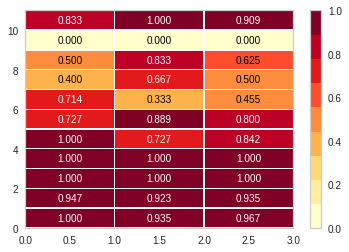

In [70]:
target_names = Classes
visualizer = ClassificationReport(random_forest_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))